# Collaboration and Competition

---


### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="./Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [5]:
states.shape

(2, 24)

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [6]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)

        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.09000000171363354


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
from actor import Actor
from critic import Critic
#from agent import Agent

In [8]:
import torch
import numpy as np

##Hyperparameters

BUFFER_SIZE = int(1e6)  # Total buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 2e-1              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate for Actor
LR_CRITIC = 3e-4        # learning rate for Critic
WEIGHT_DECAY = 0        # L2 weight decay
sd= 1e-4                ##Standard deviation of noise not used
share_memory_flag= True ## Memory shared between actors 
#                       ##so that both of them can learn from each others experience

if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

In [9]:
# the memory and the noise are shared between the actors
from memory import ReplayBuffer
from noise import OUNoise
shared_memory = ReplayBuffer( action_size,BUFFER_SIZE, BATCH_SIZE,device)
## Noise added to individual Actors. This noise is not used for this project
##I still kept it in case you want to use
noise = OUNoise(action_size, 0)

In [10]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
n_agents = num_agents
# size of each action
action_size = brain.vector_action_space_size

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]


In [11]:
#Agent0 = Agent(action_size, state_size,BUFFER_SIZE, BATCH_SIZE,LR_ACTOR,LR_CRITIC,device,WEIGHT_DECAY,seed=0)
#Agent1 = Agent(action_size, state_size,BUFFER_SIZE, BATCH_SIZE,LR_ACTOR,LR_CRITIC,device,WEIGHT_DECAY,seed=1)

In [12]:
multi_agents_actor = []
for i in range(n_agents):
    ##2 actors
    multi_agents_actor.append(Actor(action_size, state_size,BUFFER_SIZE, BATCH_SIZE,LR_ACTOR,LR_CRITIC,device,
                              WEIGHT_DECAY,TAU,shared_memory,noise,share_memory_flag,seed=i))

##One Critic for 2 actors
multi_agents_critic= Critic(action_size, state_size,BUFFER_SIZE, BATCH_SIZE,LR_ACTOR,LR_CRITIC,device,
                              WEIGHT_DECAY,TAU,share_memory_flag, seed=0)

##Note : Noise passed here is not used


In [13]:
print(multi_agents_actor[0].actor_local)

print(multi_agents_actor[1].actor_local)

print(multi_agents_critic.critic_local)

ActorNN(
  (FC1): Linear(in_features=24, out_features=512, bias=True)
  (FC2): Linear(in_features=512, out_features=256, bias=True)
  (FC3): Linear(in_features=256, out_features=2, bias=True)
)
ActorNN(
  (FC1): Linear(in_features=24, out_features=512, bias=True)
  (FC2): Linear(in_features=512, out_features=256, bias=True)
  (FC3): Linear(in_features=256, out_features=2, bias=True)
)
CriticNN(
  (FC1): Linear(in_features=24, out_features=512, bias=True)
  (FC2): Linear(in_features=514, out_features=256, bias=True)
  (FC3): Linear(in_features=256, out_features=1, bias=True)
)


### Learning Algorithm

Deep Deterministic Policy Gradient (DDPG) is an algorithm which concurrently learns a Q-function and a policy. The actor NN learns the policy here to provide us the action. The critic NN learn the Q values to let us the reward for taking the action.It can learn policies in high-dimensional, continuous action spaces.It makes use of Replay buffer so that we dont throw away the (State, action, rewards,nextState) tuple after learning from it once. SO we store them in a Deque and once the Deque size is >= Batch Size , we start sampling frm the Deque to start learning from it. It also uses target NN( to make advantage of Fixed Q Targets). The target network is a clone of the policy network. Its weights are frozen with the original policy network’s weights, and we update the weights in the target network. Here the target network is updated once per main network update by polyak averaging( TAU x current NN + (1-TAU) x TARGET NN).

The tennis game has 2 agents.I have used 2 separate actors.But I have used 1 single critic. The states are 24 sized vector. So the Q values for these State and Action taken should be same whether you are playing from right side or left side. In the previous project we have used Ornstein-Uhlenbeck Noise. But here a agent may have to move in the front or the back. So the agent is not always moving in the same direction. Hence I have not used the Ornstein-Uhlenbeck Noise. Even a standard normal noise with sd of .001 doesnt help. So I have not used the noise while training.

I have used a memory that is shared between both the actors so that each of them can learn from both the agent's experience.
This helps me converge 30 episodes earlier.

The hyperparameters: 
- Learning Rate: 1e-4 (in both Actor)  - Learning Rate: 3e-4 (in Critic)  - Batch Size: 128   - Replay Buffer: 1e6   - Gamma: 0.99   - Tau: 2e-1   For the neural models:       - Actor         - Hidden: (input, 512)  - ReLU     - Hidden: (512,256)    - ReLU     - Output: (256,2)  - TanH. The action output is clipped between -1 and 1.   - Critic     - Hidden: (input, 512)              - ReLU     - Hidden: (512 + action_size, 256)  - ReLU     - Output: (256, 1)

In [14]:
def checkpoint(n_agents, actor, critic):
    for i in range(n_agents):
        actor_checkpoint_filename = 'actor'+ str(i) + '.pth'

        torch.save(actor[i].actor_local.state_dict(), actor_checkpoint_filename)
    critic_checkpoint_filename = 'critic'+ '0' + '.pth'
    torch.save(critic.critic_local.state_dict(), critic_checkpoint_filename)

In [31]:
##Loaded last trained model
for i in range(n_agents):
    ##Load 2 actors
    actor_checkpoint_filename = 'actor'+ str(i) + '.pth'
    
    ##Load the trained actor and critic to continue training
    if os.path.exists(os.path.join('./'+ actor_checkpoint_filename)):
        multi_agents_actor[i].actor_local.load_state_dict(torch.load(os.path.join('./'+ actor_checkpoint_filename)))
        print('\tAgent',i+1,'.Actor Loaded ', end ="")

critic_checkpoint_filename = 'critic'+ '0' + '.pth'
if os.path.exists(os.path.join('./'+ critic_checkpoint_filename)):
    multi_agents_critic.critic_local.load_state_dict(torch.load(os.path.join('./'+ critic_checkpoint_filename)))
    print('\tCritic Loaded', end= '\n')

	Agent 1 .Actor Loaded 	Agent 2 .Actor Loaded 	Critic Loaded


In [23]:
from collections import namedtuple, deque
import os
scores_deque = deque(maxlen = 100)
scores = []
n_episodes=3000
best_score = -np.inf

##Loaded last trained model
for i in range(n_agents):
    ##Load 2 actors
    actor_checkpoint_filename = 'actor'+ str(i) + '.pth'
    
    ##Load the trained actor and critic to continue training
    if os.path.exists(os.path.join('./'+ actor_checkpoint_filename)):
        multi_agents_actor[i].actor_local.load_state_dict(torch.load(os.path.join('./'+ actor_checkpoint_filename)))
        print('\tAgent',i+1,'.Actor Loaded ', end ="")

critic_checkpoint_filename = 'critic'+ '0' + '.pth'
if os.path.exists(os.path.join('./'+ critic_checkpoint_filename)):
    multi_agents_critic.critic_local.load_state_dict(torch.load(os.path.join('./'+ critic_checkpoint_filename)))
    print('\tCritic Loaded', end= '\n')

for episode in range(1, n_episodes+1):
    
    env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
    states = env_info.vector_observations                 # get the current state (for each agent)
    score = np.zeros(num_agents)                          # initialize the score (for each agent)
    
    ##reset the noise
    for i in range(n_agents):
        multi_agents_actor[i].reset()
    
    while True:
        #print(episode)
        actions =[]
        ##Deal with each agent separately
        for i in range(n_agents):
            
            #multistate[i] = states[i]
            
            #states = states.reshape(1,-1)
            ##action = multi_agents[i].act(states[i].reshape(1,-1))
            action = multi_agents_actor[i].act(states[i], noise= False)
            actions.append(action)
        
        actions = np.vstack([action for action in actions])
        env_info = env.step(actions.reshape(-1))[brain_name]           # send all actions to tne environment
    
        next_states = env_info.vector_observations         # get next state (for each agent)
        #next_states = next_states.reshape(1,-1)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        
        ##Deal with each agent separately
        for i in range(n_agents):
            #print(states[i].reshape(1,-1).shape,
            #      next_states[i].reshape(1,-1).shape,actions[i].reshape(1,-1).shape )
            #print(actions[i].shape)
            
            multi_agents_actor[i].step(states[i].reshape(1,-1), actions[i].reshape(1,-1), rewards[i], 
                                 next_states[i].reshape(1,-1), dones[i])
        multi_agents_critic.step(multi_agents_actor[0], shared_memory,GAMMA)
        multi_agents_critic.step(multi_agents_actor[1], shared_memory,GAMMA)
        score += rewards                                    # update the score (for each agent)
        states = next_states                                 # roll over states to next time step
        if np.any( dones ):
            break
        ## End of 1 episode
    scores.append(np.max(score))
    scores_deque.append(np.max(score))
    print('\rEpisode: \t{} \tScore: \t{:.4f} \tAverage Score: \t{:.4f}'.format(episode, np.max(score), 
                                                                                   np.mean(scores_deque)), end="") 
    if  np.max(score) > best_score:
        best_score = np.max(score) 
        ##Save Actor and Critic for each agents
        checkpoint(n_agents, multi_agents_actor, multi_agents_critic)
    if  np.mean(scores_deque) > 0.6 and len(scores_deque) == 100:
        print('\nEnvironment solved in episode \t{}'.format(episode) )
        checkpoint(n_agents, multi_agents_actor, multi_agents_critic)
        break
    

	Agent 1 .Actor Loaded 	Agent 2 .Actor Loaded 	Critic Loaded
Episode: 	100 	Score: 	2.6000 	Average Score: 	1.6656
Environment solved in episode 	100


In [ ]:
##At the end, I just trained it a bit extra, to see what score I may achieve 
##if I go on for 100 more episodes after the milestone is achieved.

## For the plots related to the training for all the episodes from the begining of the training please see below

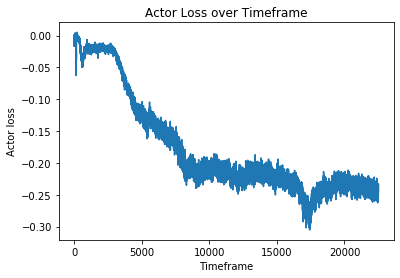

In [18]:
import matplotlib.pyplot as plt


fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(multi_agents_actor[0].actor_loss)+1), multi_agents_actor[0].actor_loss)
plt.ylabel('Actor loss')
plt.xlabel('Timeframe')
plt.title('Actor Loss over Timeframe')
plt.show()

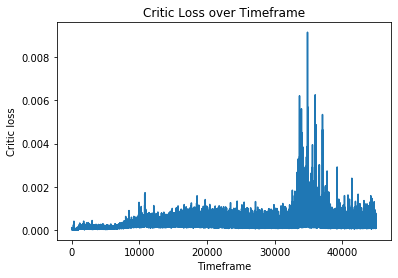

In [17]:
import matplotlib.pyplot as plt


fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(multi_agents_critic.critic_loss)+1), multi_agents_critic.critic_loss)
plt.ylabel('Critic loss')
plt.xlabel('Timeframe')
plt.title('Critic Loss over Timeframe')
plt.show()

In [11]:
#multi_agents[1].actor_loss

In [8]:
env.close()

In [ ]:
### To much oscillation with the noise

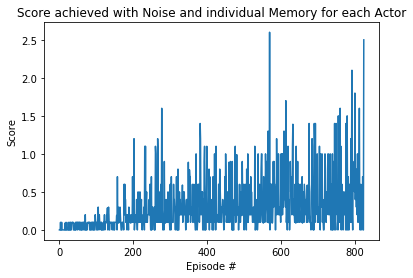

In [22]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Score achieved with Noise and individual Memory for each Actor')
plt.show();

In [27]:
## Removed noise and individual memory for each Actor

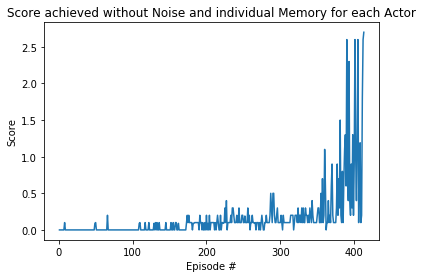

In [29]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Score achieved without Noise and individual Memory for each Actor')
plt.show();

In [ ]:
## Removed noise and memory shared between Actor
## With shared memory the network converges faster

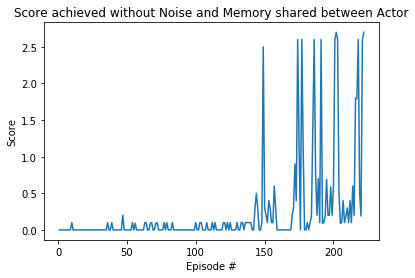

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Score achieved without Noise and Memory shared between Actor')
plt.show();

### Loaded the trained Actor

In [15]:
##Test the environment
import os
#Create the agent
multi_agents_actor = []
for i in range(n_agents):
    ##2 actors
    multi_agents_actor.append(Actor(action_size, state_size,BUFFER_SIZE, BATCH_SIZE,LR_ACTOR,LR_CRITIC,device,
                              WEIGHT_DECAY,TAU,shared_memory,noise,share_memory_flag,seed=i))

##One Critic for 2 actors
#multi_agents_critic= Critic(action_size, state_size,BUFFER_SIZE, BATCH_SIZE,LR_ACTOR,LR_CRITIC,device,
#                              WEIGHT_DECAY,TAU,share_memory_flag, seed=0)

##Loaded last trained model
for i in range(n_agents):
    ##Load 2 actors
    actor_checkpoint_filename = 'actor'+ str(i) + '.pth'
    
    ##Load the trained actor and critic to continue training
    if os.path.exists(os.path.join('./'+ actor_checkpoint_filename)):
        multi_agents_actor[i].actor_local.load_state_dict(torch.load(os.path.join('./'+ actor_checkpoint_filename)))
        print('\tAgent',i+1,'.Actor Loaded \n', end ="")


	Agent 1 .Actor Loaded 
	Agent 2 .Actor Loaded 


### Test the environment

In [17]:

for episode in range(1, 10+1):
    
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                 # get the current state (for each agent)
    score = np.zeros(num_agents)                          # initialize the score (for each agent)
    
    ##reset the noise
    for i in range(n_agents):
        multi_agents_actor[i].reset()
    
    while True:
        #print(episode)
        actions =[]
        ##Deal with each agent separately
        for i in range(n_agents):
            
            #multistate[i] = states[i]
            
            #states = states.reshape(1,-1)
            ##action = multi_agents[i].act(states[i].reshape(1,-1))
            action = multi_agents_actor[i].act(states[i], noise= False)
            actions.append(action)
        
        actions = np.vstack([action for action in actions])
        env_info = env.step(actions.reshape(-1))[brain_name]           # send all actions to tne environment
    
        next_states = env_info.vector_observations         # get next state (for each agent)
        #next_states = next_states.reshape(1,-1)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        
        score += rewards                                    # update the score (for each agent)
        states = next_states                                 # roll over states to next time step
        if np.any( dones ):
            break
        ## End of 1 episode
    #scores.append(np.max(score))
    
    print('Episode: \t{} \tScore: \t{:.2f}'.format(episode, np.max(score)))   


Episode: 	1 	Score: 	0.00
Episode: 	2 	Score: 	2.60
Episode: 	3 	Score: 	0.00
Episode: 	4 	Score: 	2.60
Episode: 	5 	Score: 	0.00
Episode: 	6 	Score: 	0.30
Episode: 	7 	Score: 	2.60
Episode: 	8 	Score: 	0.00
Episode: 	9 	Score: 	0.10
Episode: 	10 	Score: 	2.60


When finished, you can close the environment.

In [18]:
env.close()

UnityEnvironmentException: No Unity environment is loaded.

### Future Ideas

I stil want to check this task with the A2C , D4PG algorithm and discover when and where each of the algorithms (DDPG vs. D4PG) have the best performance. I also want to check if using Advantage Critic benefits this task. I want to explore I want to try with experienced replay. We may learn more from rare but important events in that case.I think we may also try N-Step boostrapping instead 1 step for bias-variance tradeoff. I think the reward calculation using GAE may also benefit.